<a href="https://colab.research.google.com/github/alouwyck/vives-deep-learning/blob/main/topic10/Chollet_HFST10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

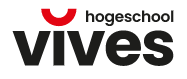<br>


**DEEP LEARNING**<br>
Academiejaar 2022-2023<br>
Andy Louwyck

---



---



# 10. Deep learning for timeseries

Deze notebook bevat de codevoorbeelden (met aanvullende uitleg) uit hoofdstuk 10 van het boek "Deep Learning with Python" (2e editie) van François Chollet.

## 10.1. Different kinds of timeseries tasks

Naast **forecasting** kan men ook andere machine learning taken uitvoeren met data die uit tijdreeksen bestaan:

- **classificatie**: tijdreeksen labelen;
- **event detection**: een verwachte gebeurtenis detecteren;
- **anomaly detection**: ongewone gebeurtenissen detecteren;
- ...

In dit hoofdstuk beperken we ons tot forecasting. Concreet gaan we adhv een dataset met échte meteorologische gegevens de temperatuur proberen te voorspellen.

## 10.2. A temperature-forecasting example

### The Jena dataset

Uit het boek:

*We’ll work with a weather timeseries dataset recorded at the weather station at the
Max Planck Institute for Biogeochemistry in Jena, Germany. In this dataset, 14 different
quantities (such as temperature, pressure, humidity, wind direction, and so on)
were recorded every 10 minutes over several years. The original data goes back to
2003, but the subset of the data we’ll download is limited to 2009–2016.*

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2022-12-09 16:09:50--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.84.221, 54.231.197.8, 52.217.228.160, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.84.221|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  14.9MB/s    in 0.9s    

2022-12-09 16:09:52 (14.9 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


We krijgen dus een csv-file en gaan die inlezen en inspecteren met Pandas:

In [ ]:
import pandas as pd

df = pd.read_csv("jena_climate_2009_2016.csv")
list(df.columns)

['Date Time',
 'p (mbar)',
 'T (degC)',
 'Tpot (K)',
 'Tdew (degC)',
 'rh (%)',
 'VPmax (mbar)',
 'VPact (mbar)',
 'VPdef (mbar)',
 'sh (g/kg)',
 'H2OC (mmol/mol)',
 'rho (g/m**3)',
 'wv (m/s)',
 'max. wv (m/s)',
 'wd (deg)']

Statistieken:

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
p (mbar),420451.0,989.212508,8.359454,913.60,984.20,989.57,994.72,1015.35
T (degC),420451.0,9.448567,8.423685,-23.01,3.36,9.41,15.47,37.28
Tpot (K),420451.0,283.491182,8.504820,250.60,277.43,283.46,289.53,311.34
Tdew (degC),420451.0,4.954011,6.730411,-25.01,0.24,5.21,10.07,23.11
rh (%),420451.0,76.007045,16.477126,12.95,65.21,79.30,89.40,100.00
VPmax (mbar),420451.0,13.575089,7.739481,0.95,7.78,11.82,17.60,63.77
VPact (mbar),420451.0,9.532524,4.183895,0.79,6.21,8.86,12.35,28.32
VPdef (mbar),420451.0,4.042483,4.897270,0.00,0.87,2.19,5.30,46.01
sh (g/kg),420451.0,6.021630,2.655973,0.50,3.92,5.59,7.80,18.13
H2OC (mmol/mol),420451.0,9.638982,4.235130,0.80,6.29,8.96,12.48,28.82


Begin- en eindtijdstip:

In [ ]:
df["Date Time"].iloc[[0, -1]]

0         01.01.2009 00:10:00
420450    01.01.2017 00:00:00
Name: Date Time, dtype: object

Plot:

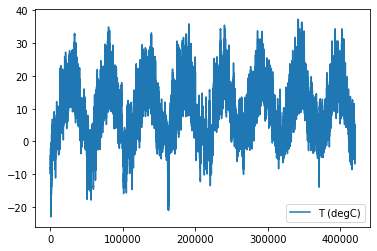

In [ ]:
df.plot(y="T (degC)");

Er is een meting om de 10 minuten. Als we willen inzoomen op de eerste 10 dagen, dan zijn dat de eerste 1440 metingen:

1440


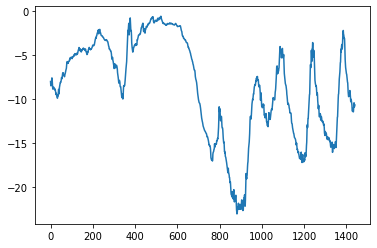

In [ ]:
i = 10 * 24 * 6  # 10 dag van 24 uren met 6 metingen per uur
print(i)
df.loc[:i, "T (degC)"].plot();

We lezen de dataset opnieuw in zoals in het boek:

In [ ]:
import os

fname = "jena_climate_2009_2016.csv"

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]

print(f"{len(header)} kolommen")
print(f"{len(lines)} rijen")

15 kolommen
420451 rijen


In [ ]:
import numpy as np

temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

Aantal samples berekenen voor de data split:

In [ ]:
num_train_samples = int(0.5 * len(raw_data))  # 50% training
num_val_samples = int(0.25 * len(raw_data))  # 25% validatie
num_test_samples = len(raw_data) - num_train_samples - num_val_samples  # 25% test
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

Ipv de `TimeseriesGenerator` gebruiken we hier de `timeseries_dataset_from_array`. Die past echter ook de sliding window methode toe. Laten we die functie eerst eens uittesten met een simpele reeks van integers van 0 tot 10:

In [ ]:
import numpy as np
from tensorflow import keras

int_sequence = np.arange(10)
print(int_sequence)
print()

m = 3
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence,
    targets=int_sequence[m:],  # pas op! [m:] is vereist!!
    sequence_length=m,
    batch_size=1,
)


for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0 1 2 3 4 5 6 7 8 9]

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7
[5, 6, 7] 8
[6, 7, 8] 9


Ter vergelijking doen we nu hetzelfde met de `TimeseriesGenerator`. Bemerk dat we hier bij `targets` gewoon de tijdreeks mogen opgeven, terwijl we bij `timeseries_dataset_from_array` de reeks moeten opgeven startend bij `m`!

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

dummy_dataset = TimeseriesGenerator(
    data=int_sequence,
    targets=int_sequence,  # [m:] niet nodig hier!
    length=m
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7
[5, 6, 7] 8
[6, 7, 8] 9


Voor het aanmaken van de input datasets nemen we de volgende inputargumenten voor functie `timeseries_dataset_from_array`:

- `sampling_rate = 6`: *Observations will be sampled at one data point per hour: we will only keep one data point out of 6.*
- `sequence_length = 120`: *Observations will go back 5 days (120 hours).*
- `delay = sampling_rate * (sequence_length + 24 - 1)`: *The target for a sequence
will be the temperature 24 hours after the end of the sequence.*

Vooraleer we de definitieve datasets aanmaken, gaan we eerst eens het effect van die inputparameters onderzoeken. Om goed te snappen wat er juist gebeurt, voegen we de tijd toe aan de arrays met observaties:

In [ ]:
t = np.arange(0, len(temperature))[:, np.newaxis] * 10  # tijd t met tijdstappen om de 10 minuten
raw_data_plus_t = np.hstack((t, raw_data.copy()))  # tijd toevoegen aan de raw data
temperature_plus_t = np.hstack((t, temperature.copy()[:, np.newaxis]))  # tijd toevoegen aan de temperatuur

We passen nu functie `timeseries_dataset_from_array` toe op de uitgebreide arrays met features en temperaturen:

In [ ]:
sampling_rate = 6  # samples bevatten metingen om het uur
sequence_length = 120  # 120 metingen per sample
delay = sampling_rate * (sequence_length + 24 - 1)  # target is 24 uur later - delay is parameter m van hierboven
print(delay)

dataset = keras.utils.timeseries_dataset_from_array(
    raw_data_plus_t[:-delay],
    targets=temperature_plus_t[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    batch_size=2,  # we willen 2 samples bekijken
    shuffle=False,  # hier shuffelen we niet omdat we de eerste 2 samples willen bekijken
    start_index=0,
    end_index=num_train_samples
)

858


We nemen de eerste batch met 2 samples:

In [ ]:
for batch, targets in dataset:  # we nemen de eerste batch
    break
batch = batch.numpy()  # tensor omzetten naar numpy array
print(batch.shape)
targets = targets.numpy()  # tensor omzetten naar numpy array
print(targets.shape)

(2, 120, 15)
(2, 2)


We plotten die eerste 2 samples op de oorspronkelijke tijdreeks:

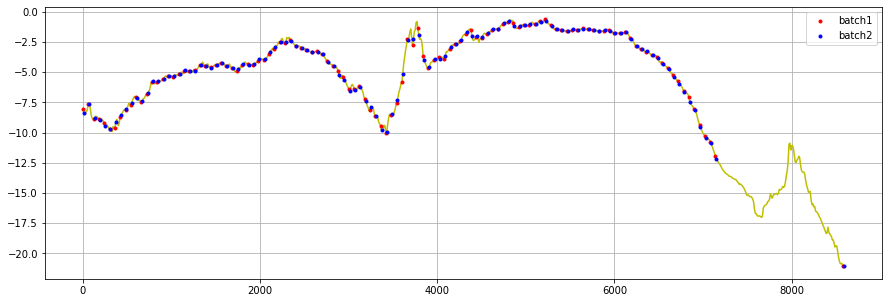

In [ ]:
from matplotlib import pyplot as plt

_, ax = plt.subplots(1, 1, figsize=(15, 5))
color = ['r', 'b']
b = ((batch[0, :, 0].min() <= t) & (t <= targets[1, 0])).squeeze()
ax.plot(t[b], temperature_plus_t[b, 1], "y-")
for i in range(2):
    ax.plot(batch[i, :, 0], batch[i, :, 2], color[i] + '.', label="batch" + str(i+1));
    ax.plot(targets[i, 0], targets[i, 1], color[i] + '.');
plt.grid();
plt.legend();

We zien dat de tweede reeks 1 meting verder ligt dan de eerste reeks. Binnen een reeks zijn de metingen inderdaad om de 6 tijdstappen gesampled. De targets van elke reeks liggen 24 uur verder en dat kunnen we als volgt checken:

In [ ]:
for i in range(2):
    print(targets[i, 0])  # tijdstip van de target
    print(batch[i, -1, 0])  # tijdstip van de laatste meting in de reeks
    print(targets[i, 0] - batch[i, -1, 0])  # verschil tussen beide
    print()

8580.0
7140.0
1440.0

8590.0
7150.0
1440.0



Het verschil tussen de laatste meting en de target is in elke sample 1440 minuten. Dat zijn exact 24 uren:

In [ ]:
1440 / 60

24.0

Als we inzoomen op het einde van de reeks, dan zien we heel duidelijk dat de `sample_rate` inderdaad 6 is:

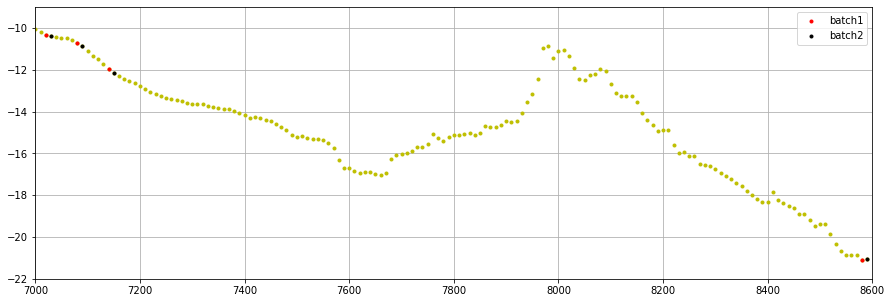

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(15, 5))
color = ['r', 'k']
b = ((batch[0, :, 0].min() <= t) & (t <= targets[1, 0])).squeeze()
ax.plot(t[b], temperature_plus_t[b, 1], "y.")
for i in range(2):
    ax.plot(batch[i, :, 0], batch[i, :, 2], color[i] + '.', label="batch" + str(i+1));
    ax.plot(targets[i, 0], targets[i, 1], color[i] + '.');
plt.xlim([7000, 8600]);
plt.ylim([-22, -9]);
plt.grid();
plt.legend();

Nu we snappen hoe de datasets worden aangemaakt, zijn we klaar om de training-, validatie- en testset aan te maken. Maar eerst moeten we de data standaardiseren:

In [ ]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

Voor het aanmaken van de uiteindelijke datasets voor training, validatie, en evaluatie nemen we een batch size van 256 en we shuffelen de samples!

In [ ]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

De shapes controleren van de batches in onze datasets:

In [ ]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, non-machine-learning baseline

Uit het boek:

*In this case, the temperature timeseries can safely be assumed to be continuous
(the temperatures tomorrow are likely to be close to the temperatures today) as
well as periodical with a daily period. Thus a common-sense approach is to always
predict that the temperature 24 hours from now will be equal to the temperature
right now.*

*Let’s evaluate this approach, using the mean absolute error (MAE) metric,
defined as follows:*

> `np.mean(np.abs(preds - targets))`

In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1]  # laatste temperatuur nemen (= 2e feature -> index 1)
        preds = preds * std[1] + mean[1]  # de-standaardiseren!
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


De naïve forecasting geeft dus een MAE van 2.62 op de testset. M.a.w. de gemiddelde absolute fout op de voorspelling is slechts 2.62 graden. Dat is onze baseline en het is duidelijk dat het niet makkelijk zal zijn om daar onder te gaan!

### Let's try a basic machine-learning model

Laten we starten met een "densely connected" model en zien wat dat geeft:

In [ ]:
from tensorflow import keras
from keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

filename = "jena_dense.keras"

callbacks = [
    keras.callbacks.ModelCheckpoint(filename,
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model(filename)
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 49s 56ms/step - loss: 12.4262 - mae: 2.7329 - val_loss: 10.9819 - val_mae: 2.6178
Epoch 2/10
819/819 [==============================] - 43s 52ms/step - loss: 9.1380 - mae: 2.3759 - val_loss: 14.4117 - val_mae: 3.0340
Epoch 3/10
819/819 [==============================] - 40s 48ms/step - loss: 8.4088 - mae: 2.2794 - val_loss: 11.8036 - val_mae: 2.7174
Epoch 4/10
819/819 [==============================] - 39s 47ms/step - loss: 7.9172 - mae: 2.2130 - val_loss: 10.6861 - val_mae: 2.5911
Epoch 5/10
819/819 [==============================] - 41s 49ms/step - loss: 7.5807 - mae: 2.1707 - val_loss: 11.2793 - val_mae: 2.6628
Epoch 6/10
819/819 [==============================] - 39s 48ms/step - loss: 7.3148 - mae: 2.1332 - val_loss: 10.8656 - val_mae: 2.6113
Epoch 7/10
819/819 [==============================] - 39s 48ms/step - loss: 7.0851 - mae: 2.0992 - val_loss: 10.6854 - val_mae: 2.5940
Epoch 8/10
819/819 [==============================] - 

De MAEs van validatie- en testset zijn ongeveer even groot als die van onze naïeve voorspeller! Als we de MAE uitplotten van training en validatie, dan zien we dat we vrij snel overfitting krijgen:

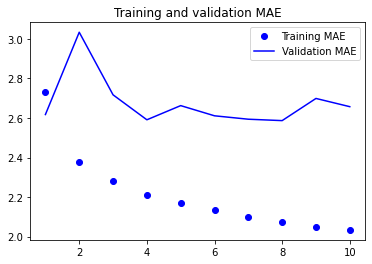

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend();

### Let's try a 1D convolutional model

Zal een convnet het beter doen?

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)  # we moeten hier Conv1D gebruiken ipv Conv2D!
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

filename = "jena_conv.keras"

callbacks = [
    keras.callbacks.ModelCheckpoint(filename,
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model(filename)
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 46s 49ms/step - loss: 22.4782 - mae: 3.7017 - val_loss: 15.6057 - val_mae: 3.1443
Epoch 2/10
819/819 [==============================] - 40s 49ms/step - loss: 15.6685 - mae: 3.1420 - val_loss: 17.1904 - val_mae: 3.2804
Epoch 3/10
819/819 [==============================] - 40s 48ms/step - loss: 14.6620 - mae: 3.0350 - val_loss: 15.0014 - val_mae: 3.0877
Epoch 4/10
819/819 [==============================] - 40s 48ms/step - loss: 13.9574 - mae: 2.9605 - val_loss: 16.4975 - val_mae: 3.2237
Epoch 5/10
819/819 [==============================] - 40s 48ms/step - loss: 13.3255 - mae: 2.8876 - val_loss: 14.3036 - val_mae: 2.9871
Epoch 6/10
819/819 [==============================] - 40s 48ms/step - loss: 12.8212 - mae: 2.8310 - val_loss: 14.0462 - val_mae: 2.9543
Epoch 7/10
819/819 [==============================] - 40s 48ms/step - loss: 12.3949 - mae: 2.7813 - val_loss: 15.2991 - val_mae: 3.0821
Epoch 8/10
819/819 [============================

De convnet doet het zelfs slechter dan onze naïeve voorspeller! En er is ook vrij snel overfitting:

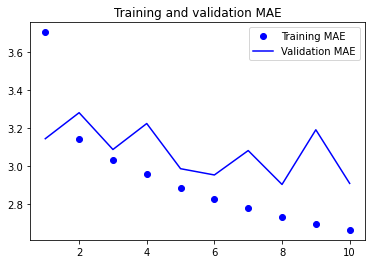

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### A first recurrent baseline

Uit het boek:

*Neither the fully connected approach nor the convolutional approach did well, but
that doesn’t mean machine learning isn’t applicable to this problem. The densely connected
approach first flattened the timeseries, which removed the notion of time
from the input data. The convolutional approach treated every segment of the data in
the same way, even applying pooling, which destroyed order information. Let’s
instead look at the data as what it is: a sequence, where causality and order matter.*

*There’s a family of neural network architectures designed specifically for this use
case: recurrent neural networks. Among them, the **Long Short Term Memory (LSTM)**
layer has long been very popular. We’ll see in a minute how these models work, but
let’s start by giving the LSTM layer a try.*

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

filename = "jena_lstm.keras"

callbacks = [
    keras.callbacks.ModelCheckpoint(filename,
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model(filename)
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 47s 54ms/step - loss: 43.0127 - mae: 4.7835 - val_loss: 13.0957 - val_mae: 2.7502
Epoch 2/10
819/819 [==============================] - 45s 55ms/step - loss: 11.2604 - mae: 2.6015 - val_loss: 9.8289 - val_mae: 2.4289
Epoch 3/10
819/819 [==============================] - 45s 55ms/step - loss: 9.8468 - mae: 2.4454 - val_loss: 9.7997 - val_mae: 2.4172
Epoch 4/10
819/819 [==============================] - 43s 53ms/step - loss: 9.3147 - mae: 2.3756 - val_loss: 9.7248 - val_mae: 2.4033
Epoch 5/10
819/819 [==============================] - 43s 53ms/step - loss: 8.9062 - mae: 2.3234 - val_loss: 9.8480 - val_mae: 2.4190
Epoch 6/10
819/819 [==============================] - 43s 53ms/step - loss: 8.6680 - mae: 2.2897 - val_loss: 9.9028 - val_mae: 2.4280
Epoch 7/10
819/819 [==============================] - 50s 61ms/step - loss: 8.4517 - mae: 2.2638 - val_loss: 9.9019 - val_mae: 2.4340
Epoch 8/10
819/819 [==============================] - 46s 5

Het LSTM model doet het beter en klopt de naïeve voorspeller! (Zij het niet op spectaculaire wijze...)

Waarom? Dat zien we in de volgende sectie!

Laten we eerst nog eens de evolutie van de MAEs van training en validatie plotten. Die ziet er ook al beter uit:

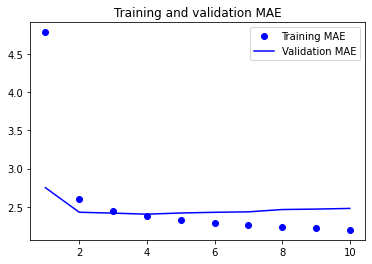

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend();

## 10.3. Understanding recurrent neural networks

De neurale netwerken die we tot nu toe hebben gezien hebben geen *geheugen*. De inputs worden onafhankelijk van elkaar verwerkt en er wordt geen toestand (*state*) bij gehouden. Tijdreeksen worden door die netwerken (*feedforward networks*) in één keer verwerkt.

Uit het boek:

*In contrast, a **recurrent neural network** (RNN) processes
sequences by iterating through the sequence elements and
maintaining a state that contains information relative to what
it has seen so far. In effect, an RNN is a type of neural network
that has an internal loop.*

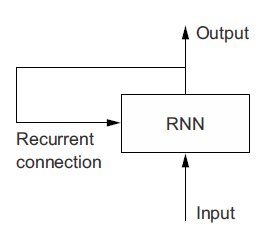

*The state of the RNN is reset between processing two different,
independent sequences (such as two samples in a
batch), so you still consider one sequence to be a single data
point: a single input to the network. What changes is that this
data point is no longer processed in a single step; rather, the
network internally loops over sequence elements.*

### RNN: naive implementation

*To make these notions of loop and state clear, let’s implement the forward pass of a
toy RNN. This RNN takes as input a sequence of vectors, which we’ll encode as a rank-2
tensor of size (timesteps, input_features). It loops over timesteps, and at each timestep,
it considers its current state at t and the input at t, and combines them to obtain the output at t. We’ll then set the state for the next step
to be this previous output. For the first timestep, the previous output isn’t defined;
hence, there is no current state. So we’ll initialize the state as an all-zero vector called
the initial state of the network.
In pseudocode, this is the RNN:*

```python
state_t = 0
for input_t in input_sequence:
    output_t = f(input_t, state_t)
    state_t = output_t
```

*You can even flesh out the function f: the transformation of the input and state into an
output will be parameterized by two matrices, W and U, and a bias vector. It’s similar to
the transformation operated by a densely connected layer in a feedforward network:*

```python
state_t = 0
for input_t in input_sequence:
    output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
    state_t = output_t
```

*To make these notions absolutely unambiguous, let’s write a naive NumPy implementation
of the forward pass of the simple RNN:*

In [ ]:
import numpy as np

timesteps = 100  # number of timesteps in the sequence
input_features = 32  # dimensionality of the input feature space
output_features = 64  # dimensionality of the output feature space

inputs = np.random.random((timesteps, input_features))  # input data: random noise for the sake of the example

state_t = np.zeros((output_features,))  # initial state: an all-zero vector
W = np.random.random((output_features, input_features))  # create random weight matrix W
U = np.random.random((output_features, output_features))  # create random weight matrix U
b = np.random.random((output_features,))  # create random bias vector

successive_outputs = []  # initialize list that stores outputs
for input_t in inputs:  # input_t is a vector of shape (input_features, )
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)  # combines input with current state
    successive_outputs.append(output_t)  # append output to list
    state_t = output_t  # update state
final_output_sequence = np.stack(successive_outputs, axis=0)  # final output has shape (timesteps, output_features)

*RNNs are characterized by their step function,
such as the following function in this case:*

```python
output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
```

*We use tanh to add non-linearity (we could use any other activation function).*

We kunnen de naïeve implementatie van een RNN schematisch als volgt weergeven (waarbij de for-loop is 'ontvouwen' in de tijd):

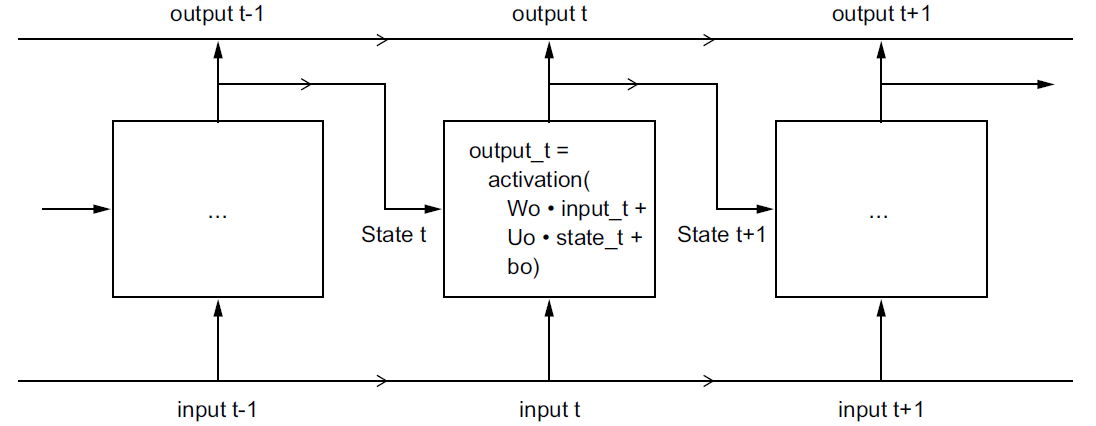

### A recurrent layer in Keras: `SimpleRNN`

De `SimpleRNN` layer in Keras implementeert het proces dat we daarnet op een naïeve manier hebben gecodeerd. Het grote verschil is dat die laag met batches kan werken, en dus is de shape van de input tensor gelijk aan `(batch_size, timesteps, input_features)`. Het aantal tijdstappen mag zelfs variëren, voor het geval de tijdreeksen in de dataset een variabele lengte hebben (wat in realiteit vaak het geval is):

In [ ]:
from tensorflow import keras
num_features = 14
inputs = keras.Input(shape=(None, num_features))  # None -> timeseries have variable length!
outputs = keras.layers.SimpleRNN(16)(inputs)

Als de tijdreeksen in de dataset wel allemaal dezelfde lengte hebben, dan is het om performantieredenen toch beter om die lengte op te geven ipv `None`.

Naast `SimpleRNN` zijn er ook nog andere recurrente layers, zoals `LSTM` en `GRU`. Al deze lagen kunnen ofwel de volledige reeks als output retourneren, of enkel het laatste element van de reeks. Dat laatste is de default en de shape van de output is dan `(batch_size, output_features)`. In het eerste geval is de shape van de output `(batch_size, timesteps, output_features)`. Welk van de twee wordt gekozen hangt af van inputparameter `return_sequences`.

In [ ]:
# An RNN layer that returns only its last output step
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = keras.layers.SimpleRNN(16, return_sequences=False)(inputs)  # default
print(outputs.shape)  # (batch_size, output_features)

(None, 16)


In [ ]:
# An RNN layer that returns its full output sequence
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = keras.layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)  # (batch_size, timesteps, output_features)

(None, 120, 16)


Wanneer RNN layers op elkaar gestapeld worden, dan moet uiteraard de volledige tijdreeks geretourneerd worden! Doe je dat niet dan krijg je een foutmelding...

In [ ]:
# Stacking RNN layers
try:
    inputs = keras.Input(shape=(steps, num_features))
    x = keras.layers.SimpleRNN(16)(inputs)
    x = keras.layers.SimpleRNN(16)(x)
    outputs = keras.layers.SimpleRNN(16)(x)
    model = keras.Model(inputs, outputs)
except Exception as error:
    print(error)
    print()
    inputs = keras.Input(shape=(steps, num_features))
    x = keras.layers.SimpleRNN(16, return_sequences=True)(inputs)  # moet True zijn!
    x = keras.layers.SimpleRNN(16, return_sequences=True)(x)  # moet True zijn!
    outputs = keras.layers.SimpleRNN(16)(x)  # mag True of False zijn...
    model = keras.Model(inputs, outputs)
model.summary()

Input 0 of layer "simple_rnn_10" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 16)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 simple_rnn_11 (SimpleRNN)   (None, 120, 16)           496       
                                                                 
 simple_rnn_12 (SimpleRNN)   (None, 120, 16)           528       
                                                                 
 simple_rnn_13 (SimpleRNN)   (None, 16)                528       
                                                                 
Total params: 1,552
Trainable params: 1,552
Non-trainable params: 0
_________________________________________________________________


De `SimpleRNN` layer wordt in de praktijk niet vaak toegepast omwille van het risico op het optreden van het **vanishing gradients problem**. De oplossing voor dat probleem is de LSTM layer!

### LSTM

Uit het boek:

*The LSTM layer is a variant of the SimpleRNN layer you already know about; it adds a way
to carry information across many timesteps. Imagine a conveyor belt running parallel
to the sequence you’re processing. Information from the sequence can jump onto the
conveyor belt at any point, be transported to a later timestep, and jump off, intact,
when you need it. This is essentially what LSTM does: it saves information for later,
thus preventing older signals from gradually vanishing during processing. This should remind you of residual connections, which you learned about in chapter 9: it’s pretty much the same idea.*

*The anatomy of an LSTM:*

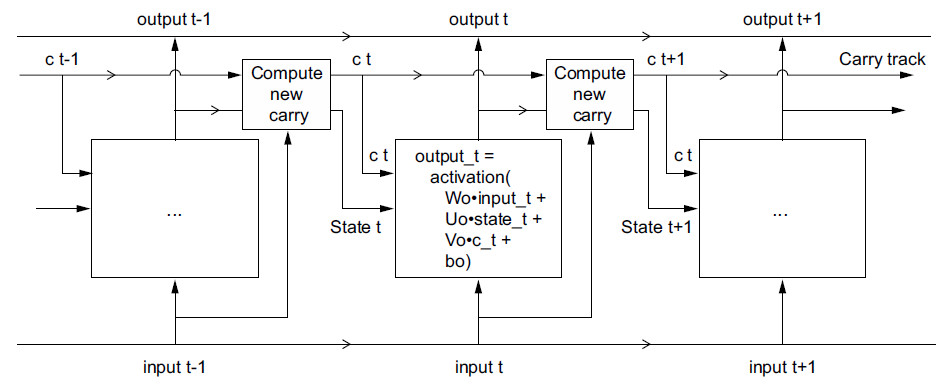

*Compared to the picture of a SimleRNN, an additional data flow is added that carries information across timesteps.
Call its values at different timesteps c_t, where C stands for carry. This information
will have the following impact on the cell: it will be combined with the input
connection and the recurrent connection (via a dense transformation: a dot product
with a weight matrix followed by a bias add and the application of an activation function),
and it will affect the state being sent to the next timestep (via an activation function
and a multiplication operation). Conceptually, the carry dataflow is a way to
modulate the next output and the next state.*

*Now the subtlety — the way the next value of the carry dataflow is computed. It involves
three distinct transformations. All three have the form of a SimpleRNN cell:*

```python
y = activation(dot(state_t, U) + dot(input_t, W) + b)
```

*But all three transformations have their own weight matrices, which we’ll index with the letters i, f, and k:*

```python
output_t = activation(dot(state_t, Uo) + dot(input_t, Wo) + dot(c_t, Vo) + bo)
i_t = activation(dot(state_t, Ui) + dot(input_t, Wi) + bi)
f_t = activation(dot(state_t, Uf) + dot(input_t, Wf) + bf)
k_t = activation(dot(state_t, Uk) + dot(input_t, Wk) + bk)
```

*We obtain the new carry state (the next c_t) by combining i_t, f_t, and k_t:*

```python
c_t+1 = i_t * k_t + c_t * f_t
```

*The combination
of operations making up an RNN cell is better interpreted as a set of constraints
on your search, not as a design in an engineering sense.
Arguably, the choice of such constraints — the question of how to implement RNN
cells — is better left to optimization algorithms (like genetic algorithms or reinforcementlearning
processes) than to human engineers. In the future, that’s how we’ll build our
models. So you don’t need to understand anything about the specific architecture
of an LSTM cell; as a human, it shouldn’t be your job to understand it. Just
keep in mind what the LSTM cell is meant to do: allow past information to be reinjected
at a later time, thus fighting the vanishing-gradient problem.*

## 10.4. Advanced use of recurrent neural networks

In dit stuk worden enkele geavanceerde technieken van RNNs besproken:
- *Recurrent dropout*
- *Stacking recurrent layers*
- *Bidirectional recurrent layers*

### Using recurrent dropout to fight overfitting

Tijdens het trainen van ons eerste LSTM model zagen we vrij snel *overfitting* optreden. Net zoals bij andere neurale netwerken kunnen we bij RNNs ook **dropout** toepassen als regularisatietechniek, alleen is het niet zo evident, want willekeurig dropout toepassen na elke tijdstap heeft een negatieve impact op het trainingproces. Dropout werkt wel als dezelfde random dropout mask wordt toegepast bij alle tijdstappen. Bovendien kan er ook een **recurrent dropout** gedefinieerd worden voor het regulariseren van de interne activaties van de LSTM eenheden. De LSTM laag heeft dus twee soorten dropout:
- `dropout`: fraction of the units to drop for the linear transformation of the inputs;
- `recurrent_dropout`: fraction of the units to drop for the linear transformation of the recurrent state.


We passen ons baseline LSTM model aan door recurrent dropout toe te voegen aan de LSTM layer. Zo kunnen we 32 eenheden ipv 16 gebruiken en zo hopen we de overfitting kunnen uitstellen. We voegen ook dropout toe na de LSTM laag om de input van de Dense layer te regulariseren. Omdat het model 'groter' is, trainen we gedurende 50 epochs ipv 10. Maar eerst moeten we nog iets zeggen over de rekentijd van RNN modellen!

Wanneer je het onderstaande model met recurrent dropout runt in Google Colab met GPU als hardware accelerator, dan zal je de volgende warning krijgen:

`Layer will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria`

Uit het boek:

*Recurrent models with very few parameters, like the ones in this chapter, tend to
be significantly faster on a multicore CPU than on GPU, because they only involve
small matrix multiplications, and the chain of multiplications is not well parallelizable
due to the presence of a for loop. But larger RNNs can greatly benefit from a
GPU runtime.
When using a Keras LSTM or GRU layer on GPU with default keyword arguments, your
layer will be leveraging a cuDNN kernel, a highly optimized, low-level, NVIDIA-provided
implementation of the underlying algorithm.
Unfortunately, recurrent dropout isn’t supported by the LSTM and GRU cuDNN kernels, so
adding it to your layers forces the runtime to fall back to the regular TensorFlow implementation,
which is generally two to five times slower on GPU (even though its computational
cost is the same).*


De criteria waaraan de LSTM layer moet voldoen om van de cuDNN kernel gebruik te kunnen maken vind je hier terug:

https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU#used-in-the-notebooks_1

Indien je geen gebruik kan maken van de cuDNN kernel, kan je de LSTM layer ook 'unrollen':

```python
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)  # set unroll to True (defauls is False)
```

Uit het boek:

*Unrolling a for loop consists of removing the loop and simply inlining its content
N times. In the case of the for loop of an RNN, unrolling can help TensorFlow optimize
the underlying computation graph. However, it will also considerably increase the memory consumption of your RNN — as such, it’s only viable for relatively small
sequences (around 100 steps or fewer). Also, note that you can only do this if the
number of timesteps in the data is known in advance by the model (that is to say, if
you pass a shape without any None entries to your initial input).*





Nu we dat weten, kiezen we gewoon voor CPU als accelerator om het LSTM model met recurrent dropout te trainen. Dat duur wel een paar uur, maar helaas is de GPU niet sneller, dus kunnen we die beter sparen...

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)  # 32 units instead of 16 and recurrent_dropout of 25%
x = layers.Dropout(0.5)(x)  # To regularize the Dense layer, we also add a Dropout layer after the LSTM.
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

filename = "jena_lstm_dropout.keras"

callbacks = [
    keras.callbacks.ModelCheckpoint(filename,
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model(filename)
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 204s 246ms/step - loss: 28.3954 - mae: 3.9318 - val_loss: 9.5360 - val_mae: 2.3949
Epoch 2/50
819/819 [==============================] - 203s 248ms/step - loss: 14.7603 - mae: 2.9806 - val_loss: 9.9088 - val_mae: 2.4358
Epoch 3/50
819/819 [==============================] - 205s 250ms/step - loss: 13.8776 - mae: 2.8864 - val_loss: 10.2395 - val_mae: 2.4950
Epoch 4/50
819/819 [==============================] - 204s 249ms/step - loss: 13.1218 - mae: 2.8091 - val_loss: 9.5139 - val_mae: 2.4033
Epoch 5/50
819/819 [==============================] - 199s 243ms/step - loss: 12.6092 - mae: 2.7534 - val_loss: 9.2097 - val_mae: 2.3664
Epoch 6/50
819/819 [==============================] - 202s 246ms/step - loss: 12.2097 - mae: 2.7047 - val_loss: 9.3910 - val_mae: 2.4020
Epoch 7/50
819/819 [==============================] - 202s 246ms/step - loss: 11.8717 - mae: 2.6702 - val_loss: 9.3689 - val_mae: 2.3773
Epoch 8/50
819/819 [====================

Het boek spreekt van een validatie MAE van 2.27 en een test MAE van 2.45 wat inderdaad significant beter is dan de test MAE gelijk aan 2.62 van onze naïeve forecasting. Ons resultaat is iets minder succesvol. Wanneer we de evolutie van de MAE uitplotten van training en validatie, dan zien we wel dat de overfitting pas rond epoch 20 optreedt, wat dus effectief een verbetering is door de recurrent dropout!

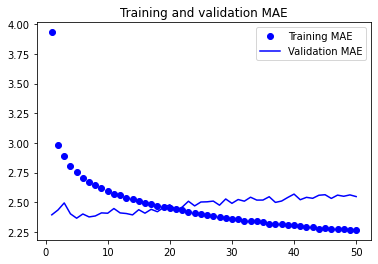

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend();

### Stacking recurrent layers

We hebben het probleem van de overfitting aangepakt, maar het lijkt er nu op dat het model niet goed genoeg presteert. Dus moeten we de capaciteit van het model vergroten, d.w.z. eenheden en/of lagen toevoegen.

Hier gaan we een extra laag toevoegen. Maar deze keer gebruiken we een **Gated Recurrent Unit** (GRU) layer. De GRU kan je zien als een recente en verbeterde versie van de LSTM, maar het achterliggende mechanisme is gelijkaardig.

Vergeet ook niet om de `return_sequences` op `True` te zetten! En we maken weer gebruik van CPU, want de GRU kan ook geen cuDNN kernel gebruiken als er recurrent dropout wordt toegepast.

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)  # return_sequences=True!
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

filename = "jena_stacked_gru_dropout.keras"

callbacks = [
    keras.callbacks.ModelCheckpoint(filename,
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model(filename)
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 338s 407ms/step - loss: 25.0065 - mae: 3.6999 - val_loss: 9.4155 - val_mae: 2.3876
Epoch 2/50
819/819 [==============================] - 332s 405ms/step - loss: 14.1180 - mae: 2.9099 - val_loss: 8.9153 - val_mae: 2.3226
Epoch 3/50
819/819 [==============================] - 330s 403ms/step - loss: 13.2211 - mae: 2.8171 - val_loss: 8.8101 - val_mae: 2.3030
Epoch 4/50
819/819 [==============================] - 331s 404ms/step - loss: 12.6645 - mae: 2.7561 - val_loss: 9.3060 - val_mae: 2.3616
Epoch 5/50
819/819 [==============================] - 331s 404ms/step - loss: 12.1778 - mae: 2.7081 - val_loss: 8.8321 - val_mae: 2.2962
Epoch 6/50
819/819 [==============================] - 329s 402ms/step - loss: 11.6790 - mae: 2.6518 - val_loss: 9.5764 - val_mae: 2.3941
Epoch 7/50
819/819 [==============================] - 331s 403ms/step - loss: 11.3166 - mae: 2.6118 - val_loss: 9.2970 - val_mae: 2.3458
Epoch 8/50
819/819 [=====================

Hier krijgen we wel duidelijk een verbetering van de MAE bij zowel validatie- als testset! De overfitting treedt op na ongeveer 10 epochs ipv 20, ook al zijn de dropout percentages hoger. Maar het model bevat natuurlijk meer parameters door de extra laag.

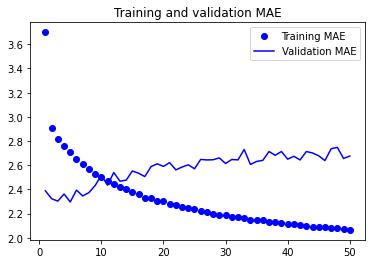

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend();

### Using bidirectional RNNs

**Training the recurrent baseline model antichronologically**

In onze dataset is de volgorde van de punten belangrijk. Dat is duidelijk. Daarom dat we de data in chronologische volgorde laten verwerken door onze neurale netwerken. M.a.w. we volgen de pijl van de tijd. Maar wat zou het geven moesten we nu van heden naar verleden gaan? Anti-chronologisch dus?

We kunnen dat vlug uittesten adhv ons eerste baseline LSTM model. We moeten dan natuurlijk wel eerst een nieuwe training-, validatie- en testset aanmaken obv de "omgedraaide" tijdreeks:

In [ ]:
raw_data_reversed = raw_data[::-1, :]  # rijen omkeren in raw_data
temperature_reversed = temperature[::-1]  # temperature omkeren

Als we de omgekeerde tijdreeks naast de oorspronkelijke plotten, dan zien we dat die inderdaad het spiegelbeeld is:

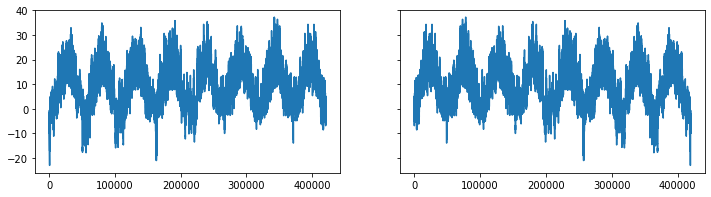

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 3))
ax1.plot(temperature);
ax2.plot(temperature_reversed);

Obv die omgekeerde tijdreeks maken we de dataset generators aan voor training, validatie en evaluatie:

In [ ]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset_reversed = keras.utils.timeseries_dataset_from_array(
    raw_data_reversed[:-delay],
    targets=temperature_reversed[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset_reversed = keras.utils.timeseries_dataset_from_array(
    raw_data_reversed[:-delay],
    targets=temperature_reversed[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset_reversed = keras.utils.timeseries_dataset_from_array(
    raw_data_reversed[:-delay],
    targets=temperature_reversed[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

En nu trainen we het model met de antichronologische reeksen:

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data_reversed.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

filename = "jena_lstm_reversed.keras"

callbacks = [
    keras.callbacks.ModelCheckpoint(filename,
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset_reversed,
                    epochs=10,
                    validation_data=val_dataset_reversed,
                    callbacks=callbacks)

model = keras.models.load_model(filename)
print(f"Test MAE: {model.evaluate(test_dataset_reversed)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 55s 60ms/step - loss: 49.1791 - mae: 5.0280 - val_loss: 17.6432 - val_mae: 3.1466
Epoch 2/10
819/819 [==============================] - 49s 60ms/step - loss: 10.8911 - mae: 2.4849 - val_loss: 13.5111 - val_mae: 2.7957
Epoch 3/10
819/819 [==============================] - 44s 53ms/step - loss: 9.3762 - mae: 2.3320 - val_loss: 13.4158 - val_mae: 2.7703
Epoch 4/10
819/819 [==============================] - 53s 65ms/step - loss: 9.0757 - mae: 2.2969 - val_loss: 13.1471 - val_mae: 2.7511
Epoch 5/10
819/819 [==============================] - 44s 53ms/step - loss: 8.8609 - mae: 2.2727 - val_loss: 13.1086 - val_mae: 2.7420
Epoch 6/10
819/819 [==============================] - 43s 53ms/step - loss: 8.6414 - mae: 2.2444 - val_loss: 13.0693 - val_mae: 2.7352
Epoch 7/10
819/819 [==============================] - 46s 55ms/step - loss: 8.4656 - mae: 2.2216 - val_loss: 13.3025 - val_mae: 2.7557
Epoch 8/10
819/819 [==============================] -

We krijgen geen significant beter resultaat dan bij hetzelfde model dat de tijdreeksen chronologisch doorliep. Ook de overfitting treedt niet later op:

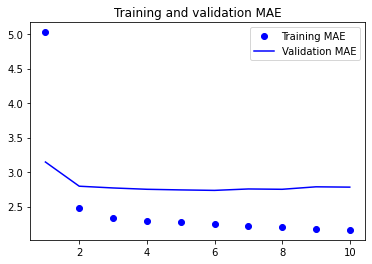

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend();

Dat is logisch, want de pijl van de tijd is belangrijk wanneer we temperaturen willen voorspellen. Inderdaad, de temperatuur van gisteren zegt meer over de temperatuur van vandaag dan de temperatuur van vorige week.

Maar dat is niet het geval bij alle problemen waar volgorde belangrijk is! Bij natural language processing (NLP) bijvoorbeeld is het wel nuttig om reeksen van woorden in twee richtingen te doorlopen. En dat kan met een bidirectioneel LSTM!

**Training and evaluating a bidirectional LSTM**

Uit het boek:

*A bidirectional RNN exploits the order sensitivity of RNNs: it uses two regular RNNs, such as the GRU and LSTM layers you’re already familiar with,
each of which processes the input sequence in one direction (chronologically and
antichronologically), and then merges their representations. By processing a sequence
both ways, a bidirectional RNN can catch patterns that may be overlooked by a unidirectional
RNN.*

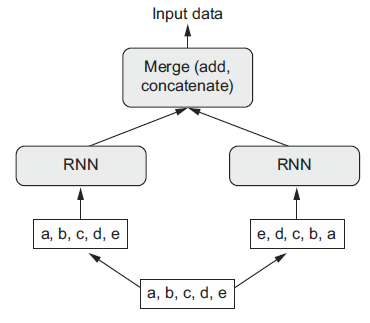

*To instantiate a bidirectional RNN in Keras, you use the* `Bidirectional` *layer, which
takes as its first argument a recurrent layer instance. Bidirectional creates a second,
separate instance of this recurrent layer and uses one instance for processing the
input sequences in chronological order and the other instance for processing the
input sequences in reversed order:*

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

filename = "jena_bidirectional_lstm.keras"

callbacks = [
    keras.callbacks.ModelCheckpoint(filename,
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model(filename)
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 150s 178ms/step - loss: 25.7067 - mae: 3.6580 - val_loss: 10.4363 - val_mae: 2.4961
Epoch 2/10
819/819 [==============================] - 146s 178ms/step - loss: 9.5913 - mae: 2.4161 - val_loss: 9.9697 - val_mae: 2.4473
Epoch 3/10
819/819 [==============================] - 151s 184ms/step - loss: 8.7291 - mae: 2.2989 - val_loss: 10.3582 - val_mae: 2.4877
Epoch 4/10
819/819 [==============================] - 145s 177ms/step - loss: 8.2053 - mae: 2.2296 - val_loss: 10.0930 - val_mae: 2.4614
Epoch 5/10
819/819 [==============================] - 149s 182ms/step - loss: 7.7594 - mae: 2.1708 - val_loss: 10.3485 - val_mae: 2.4890
Epoch 6/10
819/819 [==============================] - 146s 178ms/step - loss: 7.3603 - mae: 2.1176 - val_loss: 10.4263 - val_mae: 2.4956
Epoch 7/10
819/819 [==============================] - 148s 180ms/step - loss: 7.0759 - mae: 2.0754 - val_loss: 10.6878 - val_mae: 2.5326
Epoch 8/10
819/819 [=====================

We wisten natuurlijk al dat het doorlopen van de tijdreeks in twee richtingen geen verbetering zou opleveren in dit geval. Integendeel, we krijgen sneller overfitting omdat er nu twee keer zoveel parameters zijn!

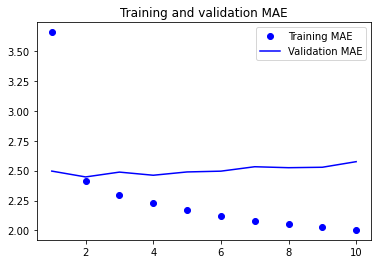

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

Maar zoals gezegd is zo'n bidirectioneel LSTM wel nuttig bij andere problemen!

Uit het boek:

*A bidirectional
RNN is a common RNN variant that can offer greater performance than a regular
RNN on certain tasks. For instance, bidirectional RNNs are a great fit for text data, or any other kind of data
where order matters, yet where which order you use doesn’t matter. In fact, for a while
in 2016, bidirectional LSTMs were considered the state of the art on many natural language
processing tasks. You could
call it the Swiss Army knife of deep learning for natural language processing!*

### Going even further

Je kan nog andere dingen uitproberen om het model te verbeteren:
- het aantal units in de LSTM of GRU lagen aanpassen
- spelen met de dropout percentages
- de learning rate verhogen of verlagen
- een andere optimizer proberen, zoals ADAM
- Dense layers toevoegen na de LSTM base
- De input aanpassen door bijv. de lengte van de reeksen te vermeerderen of te verminderen, of de sampling rate te veranderen
- ...

Uit het boek:

*As always, deep learning is more an art than a science. We can provide guidelines that
suggest what is likely to work or not work on a given problem, but, ultimately, every
dataset is unique; you’ll have to evaluate different strategies empirically.* **There is currently
no theory that will tell you in advance precisely what you should do to optimally
solve a problem. You must iterate.**

*In my experience, improving on the no-learning baseline by about 10% is likely
the best you can do with this dataset. This isn’t so great, but these results make sense:
while near-future weather is highly predictable if you have access to data from a wide
grid of different locations, it’s not very predictable if you only have measurements
from a single location. The evolution of the weather where you are depends on current
weather patterns in surrounding locations.*

En nog een belangrijke noot uit het boek over het toepassen van deep learning om op de beurs te spelen:


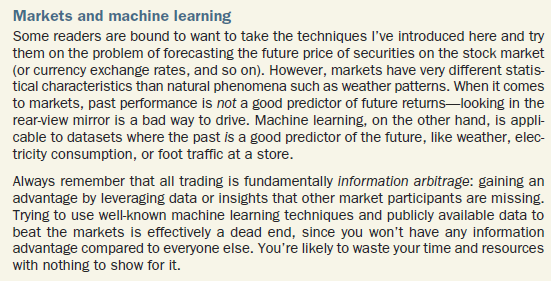

---